# Laboratorio 3 - Data Analysis 2a Parte
## Product Development - Ing. Preng Biba
### Alumno: Hugo Brian Bay Rojas - Carnet 20002544

#### Nota: La entrega empieza a partir del punto 2.4.  Todo lo anterior es lo mismo del Laboratorio 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Carga del dataset

In [94]:
data = pd.read_csv('train.csv')
print(str(data.shape) + '\n')
data.head()

(891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Eliminación de columna PassengerId y Name

In [95]:
data.drop(['PassengerId','Name'], axis=1, inplace=True)

print(str(data.shape))

(891, 10)


Estas dos columnas se eliminan ya que son datos individuales de cada observación y no son útiles para hacer una predicción.  Se tiene duda sobre las columnsa de Ticket y Cabin, pero se analizarán más adelante para saber si son útiles o no.

## 2. Análisis de datos para Feature Engineering Pipeline

### 2.1. Análisis del Target (Survived)

Primero, vemos que el tipo de dato para la variable 'Survived' en el dataset es numérico, sin embargo, por definición esta variable es categórica, por lo que es necesario forzar su tipo de dato.

In [6]:
data['Survived'].dtype

dtype('int64')

In [7]:
data['Survived'] = data['Survived'].astype('O')

In [8]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

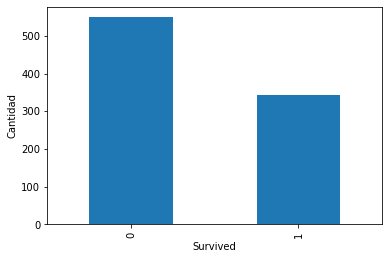

In [9]:
data['Survived'].value_counts().sort_values(ascending=False).plot.bar()
plt.ylabel('Cantidad')
plt.xlabel('Survived')
plt.show()

Al ser esta una variable categórica se debe analizar desde otro punto de vista.  Es necesario analizar el balance de los datos para asegurarnos que no habrá problema por una diferencia muy significativa entre las categorías a predecir que puedan afectar los resultados del modelo.  En este caso, los datos están bien balanceados, como podemos ver en los datos y la gráfica anteriores, los pasajeros que no sobrevivieron son 549, contra los que sobrevivieron que son 342.  La mayoría de datos son de pasajeros que no sobrevivieron, pero estos no son más del doble de los que sí sobrevivieron, por lo que no hay una desproporción significativa, sino que solo la suficiente para reflejar adecuadamente el comportamiento de los datos como tal.

Por otro lado, la variable ya está codificada con 0 y 1, por lo que no es necesario hacer ningún tipo de codificación adicional.  En conclusión, se decide no realizar ninguna transformación adicional a la variable target.

### 2.2. Verificamos los tipos de variables X

Como podemos ver a continuación, la variable 'Pclass' tiene un tipo de dato numérico, sin embargo, por definición esta variable es categórica, por lo que más adelante, cuando se haga la separación de variables categóricas y numéricas, habrá que agregarla manualmente y forzar su tipo de dato.

In [10]:
data.dtypes

Survived     object
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Identificamos las variables categóricas y agregamos manualmente 'Pclass':

In [11]:
cat_vars = [var for var in data.columns if (data[var].dtype == 'O' and var != 'Survived')]

#Agregamos el caso especial de 'Pclass', ya que por definición esta variable es categórica aunque su tipo de dato original es numérico
cat_vars = cat_vars + ['Pclass']

In [12]:
#Cantidad de variables categóricas en el dataset
len(cat_vars)

5

In [13]:
#Forzamos a todas las variables como categóricas
data[cat_vars] = data[cat_vars].astype('O')

Identificamos las variables numéricas:

In [14]:
#Variables numéricas
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'Survived')]

In [15]:
# Cantidad de variables numéricas en el dataset
len(num_vars)

4

### 2.3. Análisis de valores faltantes

In [16]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
len(var_with_na)

3

In [17]:
#proporcion de NAs en cada variable
data[var_with_na].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

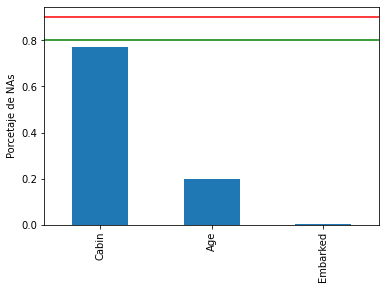

In [18]:
#Graficamos porcentajes de NAs
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel('Porcetaje de NAs')
plt.axhline(y=0.9, color='r')
plt.axhline(y=0.8, color='g')
plt.show()

In [19]:
# variables categóricas con NAs
cat_na = [var for var in cat_vars if var in var_with_na]
cat_na

['Cabin', 'Embarked']

In [20]:
#variables numéricas con NAs
num_na = [var for var in num_vars if var in var_with_na]
num_na

['Age']

In [21]:
print('Cantidad de variables numéricas con NAs. {}'.format(len(num_na)))
print('Cantidad de variables categóricas con NAs. {}'.format(len(cat_na)))

Cantidad de variables numéricas con NAs. 1
Cantidad de variables categóricas con NAs. 2


#### 2.3.1. Impacto de las variables con NA en el target (Survived)

In [22]:
def na_impact_over_target(df, Xvar, Yvar):
    df = df.copy()
    df[Yvar] = df[Yvar].astype('int')
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind='barh', y='mean', xerr='std', legend=False, title=Yvar)
    plt.show()

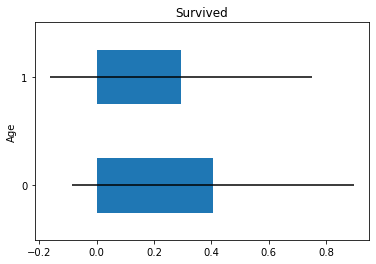

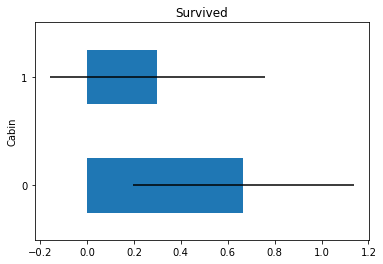

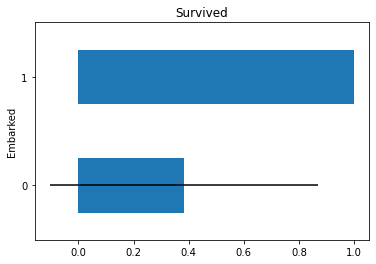

In [23]:
for var in var_with_na:
    na_impact_over_target(data, var, 'Survived')

Hay 3 variables con NAs, 2 categóricas y 1 numérica.  La cantidad de NAs en las 3 variables no es mayor al 80% en ninguno de los casos, por lo que no generan un impacto que sea tan grande como para descartar alguna de ellas.

En relación al impacto que tiene cada variable sobre el target, hay suficiente diferencia entre las medias de las observaciones que sí tienen datos contra las que tienen datos faltantes, como para decir que las 3 tienen impacto significativo en el target.

En el caso de la variable Cabin, que es la que más NAs tiene (77%), se puede observar que hay una diferencia bastante significativa entre las medias de las observaciones con NAs y las que sí tienen datos.  Esto es un indicio de que los NAs pueden tener un significado especial para el dataset y en específico relacionado al comportamiento de la variable target.  El dato como tal del número de cabina tal vez no sea relevante, pero se podría evaluar hacer una codificación binaria para identificar los que sí tienen cabina y los que no la tienen.

En conclusión, la decisión sería hacer imputación para los 3 casos de variables con datos faltantes.

### 2.4. Análisis de variables categóricas

<AxesSubplot:>

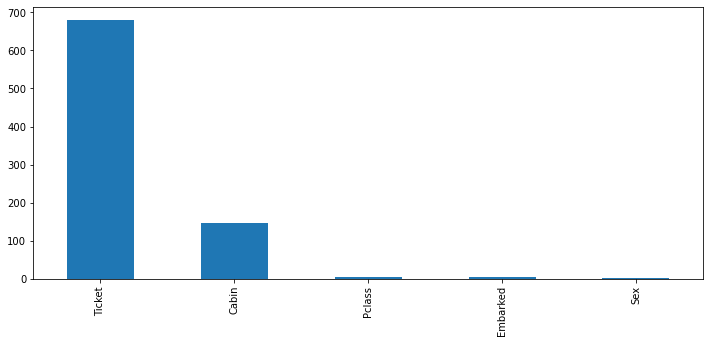

In [96]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

La variable 'Ticket' contiene 681 categorías distintas, las que más se repiten son 3, con una cantidad de 7 observaciones cada una.

#### Variable 'Ticket'

In [24]:
# Cantidad de observaciones por categoría y cantidad de categorías
data['Ticket'].value_counts().sort_values(ascending=False)

CA. 2343      7
347082        7
1601          7
347088        6
CA 2144       6
             ..
312991        1
A/4. 20589    1
350047        1
A4. 54510     1
19972         1
Name: Ticket, Length: 681, dtype: int64

Como se puede observar en la siguiente gráfica, solo algunos número de ticket tienen distinta proporción de sobrevivientes y no sobrevivientes.

In [ ]:
data_ticket = data[['Ticket', 'Survived']]
data_ticket['No_Survived'] = np.where(data_ticket['Survived'] == 0, 1,0)
data_ticket['Survived'] = data_ticket['Survived'].astype('int')
data_ticket = data_ticket.groupby('Ticket')['Survived', 'No_Survived'].agg(['sum'])

<AxesSubplot:xlabel='Ticket'>

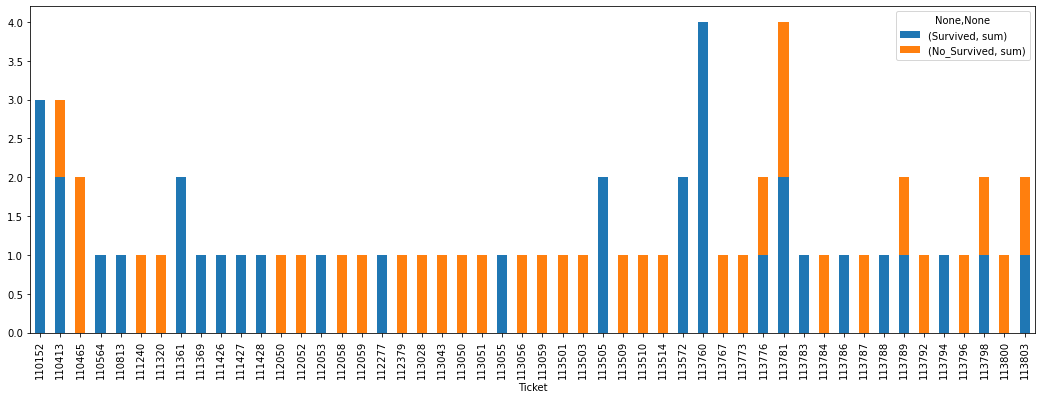

In [26]:
# Gráfica de sobrevivientes y no sobrevivientes por ticket, solo se toman las primeras 50 categorías, ya que en total son 681
data_ticket.iloc[0:50, :].plot.bar(figsize=(18,6), stacked=True)

Solo en el 38% de las observaciones se repite un número de ticket.  Esto quiere decir que en el 60% de las observaciones, por lo que se puede decir que el número de ticket no será relevante para realizar una predicción.

In [27]:
# Porcentaje de observaciones en las que se repite el número de ticket
tickets_mayores_1 = data['Ticket'].value_counts().sort_values(ascending=False) > 1
data['Ticket'][data['Ticket'].isin(tickets_mayores_1[tickets_mayores_1 == True].index) == True].count()/len(data)

0.38608305274971944

#### Variable 'Cabin'

Se analiza luego la variable 'Cabin'.  En esta podemos ver que hay 147 categorías distintas, sin embargo, tienen la característica en común que comienzan con una letra, la cual puede representar una sección (cubierta) particular del barco.  Por lo que se crea una nueva variable llamada 'Cubierta' en donde se tomará únicamente la primera letra de la cabina.  En esta categoría ya habíamos analizado que había un 77% de faltantes, pero que estos sí tenían impacto en la variable target, ya que hay una cantidad mayor de no sobrevivientes en las observaciones que no tienen dato de cabina.  Por lo que a los valores faltantes se les asigna una categoría 'X'.

In [28]:
# Cantidad de categorías y cuenta de observaciones por categoría de la variable 'Cabin'
data['Cabin'].value_counts().sort_values(ascending=False)

C23 C25 C27    4
G6             4
B96 B98        4
F2             3
E101           3
              ..
B30            1
C128           1
C110           1
C91            1
D7             1
Name: Cabin, Length: 147, dtype: int64

In [29]:
# Creación de la variable 'Cubierta' y eliminación de la variable 'Cabin'
data['Cubierta'] = data['Cabin'].str[0]
data['Cubierta'] = np.where(data['Cubierta'].isnull(), 'X', data['Cubierta'])
data.drop(['Cabin'], axis=1, inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cubierta
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,X
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,X
3,1,1,female,35.0,1,0,113803,53.1000,S,C
4,0,3,male,35.0,0,0,373450,8.0500,S,X


Ahora nos quedan solamente 9 categorías, para las cuales se podría usar frequency o density encoding para volverla numérica en pasos posteriores.  La categoría 'X' es la que representa a las observaciones que inicialmente no tenían dato en la variable 'Cabin'.

In [30]:
# Cantidad de categorías para la variable 'Cubierta'
data['Cubierta'].value_counts()

X    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cubierta, dtype: int64

#### Variable 'Embarked'

Para el caso de la variable 'Embarked', no hay ninguna transformación que realizar, esta tiene solo 3 categorías y únicamente 2 datos faltantes y se puede codificar perfectamente.  Habrá que analizar posteriormente el tipo de imputación que se puede realizar.

In [31]:
data['Embarked'].value_counts().sort_values(ascending=False)

S    644
C    168
Q     77
Name: Embarked, dtype: int64

#### Variable 'Pclass'

La variable 'Pclass' de igual forma solo tiene 3 categorías, puede realizarse un one hot encoding.

In [97]:
data['Pclass'].value_counts().sort_values(ascending=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

#### Variable 'Sex'

Para el caso de esta variable, de igual forma se realizará un one hot encoding

In [98]:
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

En el caso de este dataset no se puede realizar un análisis de impacto contra la variable target, ya que el target es categórico, este es un caso de clasificación, por lo que no es posible realizar gráficos de cajas.

### 2.5 Análisis de variables discretas

Tenemos únicamente 2 variables discretas

In [33]:
discrete_vars = [var for var in num_vars if((len(data[var].unique()) <20))]
discrete_vars

['SibSp', 'Parch']

In [34]:
data[discrete_vars].head()

,SibSp,Parch
0,1,0
1,1,0
2,0,0
3,1,0
4,0,0


Como la variable target es categórica y binaria, no se puede elaborar box plots.  Para ver el impacto que tienen las variables discretas se hace un gráfico de barras en el que se cuenta la cantidad de sobrevivientes y no sobrevivientes por categoría, para verificar que tengan impacto en el target.

En este caso, se puede visualizar en las siguientes gráficas que algunas categorías sí tienen impacto.

<ipython-input-71-5a64c70daa98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['No_Survived'] = np.where(df_new['Survived'] == 0, 1,0)
<ipython-input-71-5a64c70daa98>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Survived'] = df_new['Survived'].astype('int')
<ipython-input-71-5a64c70daa98>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new = df_new.groupby(var)['Survived', 'No_Survived'].agg(['sum'])


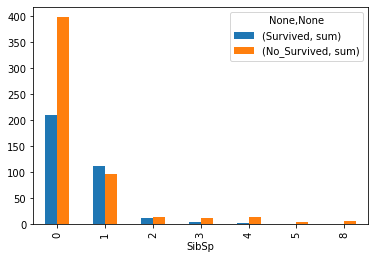

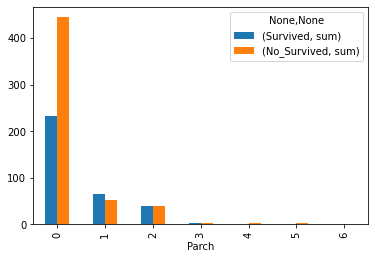

In [71]:
for var in discrete_vars:
    df_new = data[[var, 'Survived']]
    df_new['No_Survived'] = np.where(df_new['Survived'] == 0, 1,0)
    df_new['Survived'] = df_new['Survived'].astype('int')
    df_new = df_new.groupby(var)['Survived', 'No_Survived'].agg(['sum'])
    df_new.plot.bar()
    plt.show()

En las gráficas anteriores, se puede ver que las personas que de las personas que no tenían hijos ni parientes, hay una diferencia grande entre los que sobrevivieron y los que no, siendo más grande esta segunda categoría, es decir que el no tener hijos pudo ser un factor importante para no sobrevivir.

### 2.6 Análisis de variables contínuas

Tenemos 2 variables continuas, de las cuales se analiza la distribución de ambas para validar qué tan normales son, y evaluar alguna transformación.  De igual forma, los scatter plot no es posible realizarlos debido a que la variable target no es numérica.

In [73]:
cont_vars = [var for var in num_vars if var not in discrete_vars]

In [74]:
print("Variables numéricas continuas: ", len(cont_vars))

Variables numéricas continuas:  2


In [75]:
data[cont_vars].head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


Vemos como la variable 'Fare' si tiene un sesgo bastante importante, mientras que la variable 'Age' tiene un comportamiento bastante normal.

<function matplotlib.pyplot.show(close=None, block=None)>

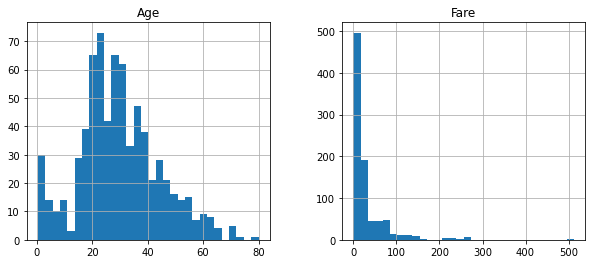

In [79]:
data[cont_vars].hist(bins=30, figsize=(10, 4))
plt.show

#### Transformación Yeo-Johnson

In [80]:
import scipy.stats as stats

In [87]:
temp_yj = data.copy()
for var in cont_vars:
    temp_yj[var], param = stats.yeojohnson(data[var])

A continuación vemos que al ejecutar la trasnformación la variable 'Fare' adquiere una mejor distribución, sin embargo, la variable 'Age' empeora.

<function matplotlib.pyplot.show(close=None, block=None)>

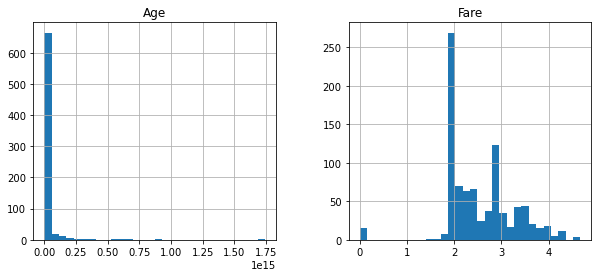

In [88]:
temp_yj[cont_vars].hist(bins=30, figsize=(10, 4))
plt.show

#### Transformación logarítmica

In [89]:
temp_log = data.copy()
for var in cont_vars:
    temp_log[var] = np.log(data[var] + 1)

Acá vemos que al aplicar la transformación logarítmica la variable 'Age' aunque no empeora tanto como con la anterior transformación, la distribución original sigue siendo mejor.

<function matplotlib.pyplot.show(close=None, block=None)>

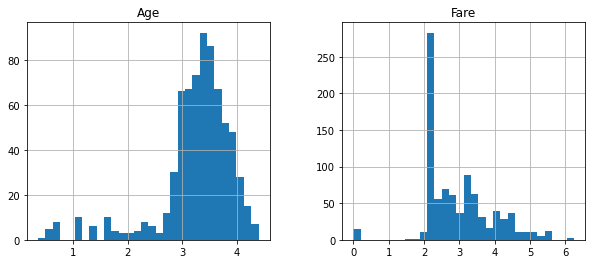

In [90]:
temp_log[cont_vars].hist(bins=30, figsize=(10, 4))
plt.show

En conclusión, se aplicará la transformación logarítmica para la variable 'Fare' y la variable 'Age' se quedará con su distribución original.

### 2.7 Rare Labels

In [101]:
def analyse_rare_labels(df, var, rare_perc):
    temp = df.groupby(var)['Survived'].count()/len(df)
    
    return temp[temp < rare_perc]

In [102]:
for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.01))
    print()

Series([], Name: Survived, dtype: float64)

Ticket
110152         0.003367
110413         0.003367
110465         0.002245
110564         0.001122
110813         0.001122
                 ...   
W./C. 6608     0.004489
W./C. 6609     0.001122
W.E.P. 5734    0.001122
W/C 14208      0.001122
WE/P 5735      0.002245
Name: Survived, Length: 681, dtype: float64

Cabin
A10    0.001122
A14    0.001122
A16    0.001122
A19    0.001122
A20    0.001122
         ...   
F33    0.003367
F38    0.001122
F4     0.002245
G6     0.004489
T      0.001122
Name: Survived, Length: 147, dtype: float64

Series([], Name: Survived, dtype: float64)

Series([], Name: Survived, dtype: float64)



En el análisis de etiquetas raras, vemos que las únicas variables que las tienen son 'Ticket' y 'Cabin'.  En el primer caso, como ya habíamos revisado antes, son muchísimas categorías que no agrupa mayor cantidad de datos, por lo que la variable seguramente no aporta mayor cosa al modelo.  En el caso de la variable 'Cabin' ya se propuso cómo transformarla para que sea una variable que aporte información significativa.